# Model Tuning

Now that I have established that I can train a model to drive the car, I will start building a CNN that can successfully complete a lap.
I have learned much from [this article by Jason Brownlee on the subject](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/), which was linked to me by my DSI-830 instructor Patrick Waled-Dinian

Plan:
* Import numpy arrays X and y 
* Create train-test split
* Assemble a Convolutional Neural Network
* Use KerasTuner to find optimal hyperparameters
* Fit and assess CNN
* Save model to test driving

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from keras_tuner import BayesianOptimization, Hyperband, HyperModel

from os.path import exists

from tensorflow import keras
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.metrics import MAE, MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2021-11-12 18:55:44.963369: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [6]:
## Constants
working_date = '11_12_2021'
working_time = '19_28_18'

model_history_file = '../models/model_history.csv'

In [7]:
## Directories
data_directory = f'../data/{working_date}/{working_time}'
model_directory = f'../models/{working_date}/{working_time}'

## File paths
input_dataset_file = f'{data_directory}/X_img.npy'
target_dataset_file = f'{data_directory}/y.npy'

In [8]:
## Make sure model history exists
if not exists(model_history_file):
    model_history = pd.DataFrame(columns=['model', 'history', 
                                          'r2_score', 'mae_score',
                                          'mse_score', 'rmse_score'])
else:
    model_history = pd.read_csv(model_history_file, index_col=0)

## Data

### Load Datasets

In [9]:
## Load the datasets
X = np.load(input_dataset_file)
y = np.load(target_dataset_file)

### Create Train/Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=0)

## Model

sources: 

* [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
* [Hands on hyperparameter tuning with Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner) by Julie Prost

Hyperparameters:
* Number of convolutional layers
* number of filters
* size of filters
* number of dense layers
* units in dense layers
* dropout values
* adam learning rate

### Create Framework

In [40]:
# Lesson 8.03
# https://docs.donkeycar.com/dev_guide/model/

class ImgHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        kernels = [3, 5,]# 7,]
        filters = [8, 16, 32,]# 64,]
        units = [16, 32, 64, 128, 256]
        drops = [0.0, 0.1, 0.2, 0.3, 0.4,]
        strides = [1, 2]
        
        # Image Model
        inputs = Input(shape=self.input_shape, name='inputs')
        
        # First Hidden Layer
        layers = Conv2D(
                filters=hp.Choice(f'c_filters_0',values=filters), 
                kernel_size=hp.Choice(f'kernel_0', values=kernels),
                strides=hp.Choice(f'stride_0', values=strides)
            )(inputs)
        
        # Add convolutional layers        
        for i in range(1, 5):
            layers = Conv2D(
                padding='same',
                filters=hp.Choice(f'c_filters_{i}',values=filters), 
                kernel_size=hp.Choice(f'kernel_{i}', values=kernels),
                strides=hp.Choice(f'stride_{i}', values=strides)
            )(layers)
            # Add dropout
            layers = Dropout(
                rate=hp.Choice(f'c_drop_{i}', values=drops)
            )(layers)
            
        ## Flatten
        layers =Flatten()(layers)
        
        # Add dense layers
        for j in range(4):
            layers = Dense(units=hp.Choice(f'd_units_{j}', values=units), 
                           activation='relu'
                          )(layers)
            layers = Dropout(rate=hp.Choice(f'd_drop_{j}', values=drops))(layers)
            
        # Output Layer
        output = Dense(2, activation='linear', name='outputs')(layers)
        
        # Create Model
        model = Model(inputs=inputs, outputs=output)
            
        # Compile Model
        model.compile(
            optimizer=Adam(learning_rate=0.0001),
            loss=MSE,
            metrics=[MAE]
        )
        
        return model

In [42]:
input_shape = X_train[0].shape
input_shape

(60, 80, 1)

### Create Tuner

In [49]:
hypermodel = ImgHyperModel(input_shape)

tuner = BayesianOptimization(hypermodel, 
                             objective='val_loss',
                             beta=2.8,
                             max_trials=100, 
                             seed=0, 
                             overwrite=True)

# tuner = Hyperband(hypermodel, 
#                   objective='val_loss',
#                   max_epochs=25,
#                   factor=3,
#                   hyperband_iterations=2, 
#                   seed=0,
#                   overwrite=True,);

### Search

In [50]:
stop_early = EarlyStopping(patience=5)

In [51]:
tuner.search(X_train, y_train, 
             validation_data=(X_test, y_test), 
             callbacks=[stop_early],
             batch_size=32,
             epochs=25,
             verbose=1)

Trial 100 Complete [00h 01m 28s]
val_loss: 0.017206761986017227

Best val_loss So Far: 0.01599992625415325
Total elapsed time: 02h 37m 54s
INFO:tensorflow:Oracle triggered exit


### Fit

In [62]:
## https://www.tensorflow.org/tutorials/keras/keras_tuner
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

In [63]:
# best_hps.values

In [64]:
## Fit the best model
results = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=500, 
                    validation_data=(X_test, y_test), 
                   # verbose=0)
                    callbacks=[stop_early])

Epoch 1/500
526/526 [==============================] - 26s 32ms/step - loss: 0.1457 - mean_absolute_error: 0.2934 - val_loss: 0.0434 - val_mean_absolute_error: 0.1457
Epoch 2/500
526/526 [==============================] - 5s 10ms/step - loss: 0.0505 - mean_absolute_error: 0.1553 - val_loss: 0.0303 - val_mean_absolute_error: 0.1173
Epoch 3/500
526/526 [==============================] - 5s 10ms/step - loss: 0.0367 - mean_absolute_error: 0.1304 - val_loss: 0.0258 - val_mean_absolute_error: 0.1075
Epoch 4/500
526/526 [==============================] - 5s 10ms/step - loss: 0.0328 - mean_absolute_error: 0.1214 - val_loss: 0.0240 - val_mean_absolute_error: 0.1030
Epoch 5/500
526/526 [==============================] - 5s 10ms/step - loss: 0.0291 - mean_absolute_error: 0.1133 - val_loss: 0.0273 - val_mean_absolute_error: 0.1085
Epoch 6/500
526/526 [==============================] - 5s 10ms/step - loss: 0.0277 - mean_absolute_error: 0.1107 - val_loss: 0.0230 - val_mean_absolute_error: 0.0946
Epo

In [24]:
model.evaluate(X_train, y_train)

263/263 [==============================] - 2s 8ms/step - loss: 0.0088 - mean_absolute_error: 0.0716


[0.008819726295769215, 0.07162034511566162]

In [25]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 7ms/step - loss: 0.0218 - mean_absolute_error: 0.1023


[0.021828357130289078, 0.10228771716356277]

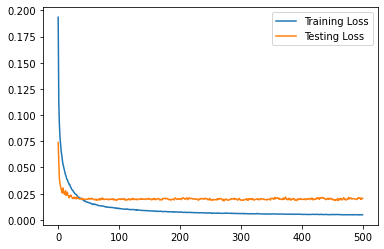

In [19]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.legend();

In [52]:
plt.plot(results.history['mean_absolute_error'], label = 'Training MAE')
plt.plot(results.history['val_mean_absolute_error'], label = 'Testing MAE')
plt.legend();

NameError: name 'results' is not defined

In [166]:
preds = model.predict(X_test)

In [167]:
## r2 
# print(f'Train R2:   {metrics.r2_score(y_train, model.predict(X_train)): .4f}')
print(f'Test R2:    {metrics.r2_score(y_test, preds): .4f}')
print("==================")
## MAE
# print(f'Train MAE:  {metrics.mean_absolute_error(y_train, model.predict(X_train)): .4f}')
print(f'Test MAE:   {metrics.mean_absolute_error(y_test, preds): .4f}')
print("===================")
## MSE
# print(f'Train MSE:  {metrics.mean_squared_error(y_train, model.predict(X_train)): .4f}')
print(f'Test MSE:   {metrics.mean_squared_error(y_test, preds): .4f}')
print("===================")
## RMSE
# print(f'Train RMSE: {metrics.mean_squared_error(y_train, model.predict(X_train), squared=False): .4f}')
print(f'Test RMSE:  {metrics.mean_squared_error(y_test, preds, squared=False): .4f}')

Test R2:     0.8938
Test MAE:    0.0594
Test MSE:    0.0153
Test RMSE:   0.1204


## Save model

In [149]:
model_index = max(0, model_history.index.max() + 1)
model_path = f'{model_directory}/model_{model_index}.h5'

history_dictionary = {
    'model': model_path,
    'history': results.history,
    'r2_score': metrics.r2_score(y_test, preds),
    'mae_score': metrics.mean_absolute_error(y_test, preds),
    'mse_score': metrics.mean_squared_error(y_test, preds),
    'rmse_score': metrics.mean_squared_error(y_test, preds, squared=False),
}

model_history = model_history.append(history_dictionary, ignore_index=True)
model_history.tail()

,model,history,mae_score,mse_score,r2_score,rmse_score
25,../models/11_08_2021/22_04_06/model_25.h5,"{'loss': [0.07831844687461853, 0.0440239384770...",0.101922,0.023065,0.837876,0.148818
26,../models/11_08_2021/22_04_06/model_26.h5,"{'loss': [0.30734896659851074, 0.1347967237234...",0.093897,0.020349,0.856093,0.140199
27,../models/11_08_2021/22_04_06/model_27.h5,"{'loss': [0.48574620485305786, 0.2133759558200...",0.093619,0.018737,0.866533,0.134962
28,../models/11_08_2021/22_04_06/model_28.h5,"{'loss': [0.26421430706977844, 0.1779259294271...",0.093748,0.017361,0.878052,0.129068
29,../models/11_08_2021/22_04_06/model_29.h5,"{'loss': [0.30777809023857117, 0.1796961575746...",0.059195,0.012069,0.913797,0.108437


In [150]:
## Saving as h5 for backwards compatibility
model.save(model_path, save_format='h5')
model_history.to_csv(model_history_file)

In [151]:
model_path

'../models/11_08_2021/22_04_06/model_29.h5'